# **COMM061 Postgraduate Group 11**

Members:<br>
- 6889747 Yi Zeng
- 6794870 Haodong Li
- 6893621 Terry Szeto
- 6896458 Olushola Olateju

# 1. Analyse and visualise the dataset

# 2. Experimentation with three different setups

In [191]:
import sys

# If run in colab instead of local
if 'google.colab' in sys.modules:
    # Install any dependencies
    !pip install -U datasets
    !pip install transformers seqeval evaluate gensim torch

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from transformers import BertTokenizerFast, BertModel
import datasets
from gensim.models import Word2Vec
import numpy as np
from seqeval.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

dataset = datasets.load_dataset('surrey-nlp/PLOD-CW-25')
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

dataset_ext = datasets.load_dataset('surrey-nlp/PLODv2-filtered')
train_data_ext = dataset_ext['train']
val_data_ext = dataset_ext['validation']
test_data_ext = dataset_ext['test']

## 2.1 Vary the text encoding
a. Data pre-processing technique: no preprocessing  
b. (varied) Text encoding/transformation into embeddings: word2vec, GloVe, pre-trained language model(BERT)  
c. Modelling Technique: LSTM with FC layer

In [21]:
%%time
#The original glove file is 300mb, but we only need a portion of the words, search them and save them in NPZ format
def convert_glove_to_npz(glove_path, output_npz_path):
    word_counts = Counter()
    for sentence in train_data:
        word_counts.update(sentence['tokens'])
    for sentence in train_data_ext:
        word_counts.update(sentence['tokens'])
    vocab_all = ['<PAD>', '<UNK>'] + [word for word, count in sorted(word_counts.items(), key = lambda x:-x[1])]#sort by frequency
    word2id_all = {word: idx for idx, word in enumerate(vocab_all)}

    words = {}
    vectors = np.zeros((len(vocab_all), 100), dtype=np.float32)
    count = 0
    with open(glove_path, 'r', encoding='utf-8') as f:
        for idx, line in tqdm(enumerate(f), total=400000, desc="Processing"):
            row = line.rstrip().split()
            if row[0] in vocab_all:
                count += 1
                words[row[0]] = word2id_all[row[0]]
                vectors[word2id_all[row[0]]] = np.array(row[1:], dtype=np.float32)

    np.savez_compressed(
        output_npz_path,
        words=words,
        vectors=vectors
    )
    print(f"Saved compressed GloVe to {output_npz_path}, found {count}/{len(vocab_all)} words")

#convert_glove_to_npz("glove.6B.100d.txt", "glove.6B.100d.PLOD-CW-25.npz")

CPU times: total: 0 ns
Wall time: 0 ns


In [24]:
#Init
class Config:
    GLOVE_NPZ_PATH = 'glove.6B.100d.PLOD-CW-25.npz'
    EMBEDDING_VEC = 100
    HIDDEN = 128
    BATCH_SIZE = 32
    EPOCHS = 20
    BERT_MODEL_NAME = 'bert-base-cased'
    NUM_LSTM_LAYERS = 2
    NUM_RNN_LAYERS = 2
    MAX_LENGTH = 128
    LEARNING_RATE = 1e-5
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [193]:
#Build vocabulary, convert to ID
def build_vocab_id(data):
    word_counts = Counter()
    for sentence in data:
        word_counts.update(sentence['tokens'])
    vocab = ['<PAD>', '<UNK>'] + [word for word, count in sorted(word_counts.items(), key = lambda x:-x[1])]#sort by frequency
    word2id = {word: idx for idx, word in enumerate(vocab)}
    return vocab, word2id

vocab, word2id = build_vocab_id(train_data)

#Convert ner_tags to ID
ner_labels = set()
for split in [train_data, val_data, test_data]:
    for data in split:
        ner_labels.update(data['ner_tags'])
ner_tag2id = {tag: idx for idx, tag in enumerate(ner_labels)}
id2ner = {v: k for k, v in ner_tag2id.items()}

In [30]:
#Word2Vec
def build_w2v_matrix(word2id, w2v_model):
    embedding_w2v_matrix = np.zeros((len(vocab), Config.EMBEDDING_VEC))
    for word, idx in word2id.items():
        if word in w2v_model.wv:
            embedding_w2v_matrix[idx] = w2v_model.wv[word]
        elif word == '<PAD>':
            embedding_w2v_matrix[idx] = np.zeros(Config.EMBEDDING_VEC)
        else:
            embedding_w2v_matrix[idx] = np.random.normal(size=(Config.EMBEDDING_VEC,))
    return embedding_w2v_matrix

w2v_model = Word2Vec(train_data['tokens'], vector_size=Config.EMBEDDING_VEC, window=3, min_count=1, workers=4, epochs=50)
embedding_w2v_matrix = build_w2v_matrix(word2id, w2v_model)

In [33]:
#GloVe
def load_compressed_glove(npz_path):
    data = np.load(npz_path, mmap_mode='r', allow_pickle=True)
    return data['words'], data['vectors']

glove_words, glove_vectors = load_compressed_glove(Config.GLOVE_NPZ_PATH)

def build_glove_matrix(word2id, glove_words, glove_vectors):
    embedding_glove_matrix = np.zeros((len(word2id), Config.EMBEDDING_VEC))
    for word, idx in word2id.items():
        if word in glove_words:
            embedding_glove_matrix[idx] = glove_vectors[glove_words['word']]
        elif word == '<PAD>':
            embedding_glove_matrix[idx] = np.zeros(Config.EMBEDDING_VEC)
        else:
            embedding_glove_matrix[idx] = np.random.normal(size=(Config.EMBEDDING_VEC,))
    return embedding_glove_matrix

embedding_glove_matrix = build_glove_matrix(word2id, glove_words, glove_vectors)

In [36]:
#pre-trained language model: BERT
tokenizer = BertTokenizerFast.from_pretrained(Config.BERT_MODEL_NAME)

In [40]:
#Custom dataset
class NER_Dataset(Dataset):
    def __init__(self, data, embedding_type = None, tokenizer = None):
        self.data = data
        self.embedding_type = embedding_type
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sentence = self.data[idx]
        tokens = sentence['tokens']
        ner_tags = sentence['ner_tags']

        if self.embedding_type == 'BERT':#BERT
            encoding = self.tokenizer(
            tokens,
            is_split_into_words=True,
            truncation=True,
            max_length=Config.MAX_LENGTH,
            padding=False
            )

            word_ids = encoding.word_ids()
            labels = []
            current_word_id = None
            
            for word_id in word_ids:
                if word_id is None:
                    labels.append(-100)
                else:
                    if word_id != current_word_id:
                        labels.append(ner_tag2id[ner_tags[word_id]])
                        current_word_id = word_id
                    else:
                        labels.append(-100)
    
            return {
                'input_ids': encoding['input_ids'],
                'attention_mask': encoding['attention_mask'],
                'labels': labels
            }
        else:
            token_ids = [word2id.get(token, word2id['<UNK>']) for token in tokens]
            ner_ids = [ner_tag2id[tag] for tag in ner_tags]
            
            return {
                'token_ids': torch.LongTensor(token_ids),
                'ner_ids': torch.LongTensor(ner_ids),
                'lengths': len(token_ids)
            }

#Custom collate fuction
def collate_fn(batch):
    if 'attention_mask' in batch[0]:#BERT
        max_length = max(len(x['input_ids']) for x in batch)
    
        input_ids = []
        attention_masks = []
        labels = []
        
        for x in batch:
            pad_length = max_length - len(x['input_ids'])
            input_ids.append(x['input_ids'] + [tokenizer.pad_token_id] * pad_length)
            attention_masks.append(x['attention_mask'] + [0] * pad_length)
            labels.append(x['labels'] + [-100] * pad_length)
        
        return {
            'input_ids': torch.LongTensor(input_ids).to(Config.DEVICE),
            'attention_mask': torch.LongTensor(attention_masks).to(Config.DEVICE),
            'labels': torch.LongTensor(labels).to(Config.DEVICE)
        }
    else:
        token_ids = [x['token_ids'] for x in batch]
        ner_ids = [x['ner_ids'] for x in batch]
        lengths = [x['lengths'] for x in batch]
        
        sorted_indices = np.argsort(lengths)[::-1]
        token_ids = [token_ids[i] for i in sorted_indices]
        ner_ids = [ner_ids[i] for i in sorted_indices]
        lengths = [lengths[i] for i in sorted_indices]
    
        #Fill to the same length
        token_ids = pad_sequence(token_ids, batch_first=True, padding_value=word2id['<PAD>'])
        ner_ids = pad_sequence(ner_ids, batch_first=True, padding_value=-100)
        
        return {
            'token_ids': token_ids.to(Config.DEVICE),
            'ner_ids': ner_ids.to(Config.DEVICE),
            'lengths': torch.LongTensor(lengths).to(Config.DEVICE)
        }

In [43]:
#Word2Vec&GloVe
train_dataset = NER_Dataset(train_data)
val_dataset = NER_Dataset(val_data)
test_dataset = NER_Dataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)

#BERT
train_dataset_bert = NER_Dataset(train_data, 'BERT', tokenizer)
val_dataset_bert = NER_Dataset(val_data, 'BERT', tokenizer)
test_dataset_bert = NER_Dataset(test_data, 'BERT', tokenizer)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=Config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=Config.BATCH_SIZE, collate_fn=collate_fn)

In [49]:
#Init model
class NER_Model(nn.Module):
    def __init__(self, embedding_type, model_type='LSTM'):
        super().__init__()
        self.embedding_type = embedding_type
        self.model_type = model_type

        if self.embedding_type == 'Word2Vec':
            self.embedding = nn.Embedding.from_pretrained(
                torch.FloatTensor(embedding_w2v_matrix),
                padding_idx=word2id['<PAD>']
            )
            self.lstm = nn.LSTM(Config.EMBEDDING_VEC, Config.HIDDEN, bidirectional=True, num_layers=Config.NUM_LSTM_LAYERS, dropout=0.3)
        elif self.embedding_type == 'GloVe':
            self.embedding = nn.Embedding.from_pretrained(
                torch.FloatTensor(embedding_glove_matrix),
                padding_idx=word2id['<PAD>']
            )
            self.lstm = nn.LSTM(Config.EMBEDDING_VEC, Config.HIDDEN, bidirectional=True, num_layers=Config.NUM_LSTM_LAYERS, dropout=0.3)
        elif self.embedding_type == 'BERT':
            self.bertmodel = BertModel.from_pretrained(Config.BERT_MODEL_NAME)
            self.lstm = nn.LSTM(
            input_size=self.bertmodel.config.hidden_size,
            hidden_size=Config.HIDDEN,
            num_layers=Config.NUM_LSTM_LAYERS,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
            )
            self.rnn = nn.RNN(
            input_size=self.bertmodel.config.hidden_size,
            hidden_size=Config.HIDDEN,
            num_layers=Config.NUM_RNN_LAYERS,
            bidirectional=True,
            batch_first=True,
            nonlinearity='relu',
            dropout=0.3
            )
        self.fc = nn.Linear(Config.HIDDEN*2, len(ner_tag2id))
        
    def forward(self, token_ids=None, lengths=None, input_ids=None, attention_mask=None):
        if self.embedding_type == 'BERT':
            outputs = self.bertmodel(input_ids=input_ids, attention_mask=attention_mask)
            sequence_output = outputs.last_hidden_state
            if self.model_type == 'LSTM':
                output, _ = self.lstm(sequence_output)
            else:
                output, _ = self.rnn(sequence_output)
            return self.fc(output)
        else:
            emb_tokens = self.embedding(token_ids)
            packed = pack_padded_sequence(emb_tokens, lengths.cpu(), batch_first=True, enforce_sorted=False)
            output, _ = self.lstm(packed)
            output, _ = pad_packed_sequence(output, batch_first=True)
            return self.fc(output)

In [78]:
def eval_ner(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report['micro avg']['precision']
    recall = report['micro avg']['recall']
    f1 = report['micro avg']['f1-score']

    return precision, recall, f1, report

In [135]:
#Init training
def training(model, model_name, embedding_type, train_loader, val_loader):
    best_f1 = -1
    train_loss_list = []
    val_loss_list = []
    for epoch in range(Config.EPOCHS):
        #Train
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            if embedding_type == 'BERT':#BERT
                logits = model(None, None, batch['input_ids'], batch['attention_mask'])
                loss = criterion(logits.view(-1, len(ner_tag2id)), batch['labels'].view(-1))
            else:
                logits = model(batch['token_ids'], batch['lengths'], None, None)
                loss = criterion(logits.view(-1, len(ner_tag2id)), batch['ner_ids'].view(-1))         
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        #Evaluate
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}"):
                if embedding_type == 'BERT':#BERT
                    logits = model(None, None, batch['input_ids'], batch['attention_mask'])
                    loss = criterion(logits.view(-1, len(ner_tag2id)), batch['labels'].view(-1))
                    val_loss += loss.item()
                    
                    preds = torch.argmax(logits, dim=-1).cpu().numpy()
                    labels = batch['labels'].cpu().numpy()

                    for i in range(preds.shape[0]):
                        valid_labels = []
                        valid_preds = []
                        for j in range(preds.shape[1]):
                            if labels[i][j] != -100:
                                valid_labels.append(id2ner[labels[i][j]])
                                valid_preds.append(id2ner[preds[i][j]])
                        all_labels.append(valid_labels)
                        all_preds.append(valid_preds)
                else:
                    logits = model(batch['token_ids'], batch['lengths'], None, None)
                    loss = criterion(logits.view(-1, len(ner_tag2id)), batch['ner_ids'].view(-1)) 
                    val_loss += loss.item()
                    
                    preds = torch.argmax(logits, dim=-1).cpu().numpy()
                    labels = batch['ner_ids'].cpu().numpy()

                    for i in range(len(batch['lengths'])):
                        valid_preds = []
                        valid_labels = []
                        length = batch['lengths'][i]
                        result_preds = preds[i, :length]
                        result_labels = labels[i, :length]
                        mask = result_labels != -100
                        for i in result_preds[mask].tolist():
                            valid_preds.append(id2ner[i])
                        for i in result_labels[mask].tolist():
                            valid_labels.append(id2ner[i])
                        all_preds.append(valid_preds)
                        all_labels.append(valid_labels)

        _, _, val_f1, _ = eval_ner(all_labels, all_preds)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
    
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), model_name)
            print('Best model saved!')
        
        print(f"Epoch {epoch+1}/{Config.EPOCHS}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val F1: {val_f1:.4f}\n")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, 'b', label='Training Loss', marker='o')
    plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, 'r', label='Validation Loss', marker='o')
    plt.title('Training & Validation Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

BERT+LSTM type training...


Validating Epoch 1: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.47it/s]


Best model saved!
Epoch 1/20
Train Loss: 1.0275
Val Loss: 0.9279
Val F1: 0.0000



Validating Epoch 2: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.16it/s]


Best model saved!
Epoch 2/20
Train Loss: 0.8249
Val Loss: 0.7501
Val F1: 0.0063



Validating Epoch 3: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


Best model saved!
Epoch 3/20
Train Loss: 0.6969
Val Loss: 0.6704
Val F1: 0.2454



Validating Epoch 4: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


Best model saved!
Epoch 4/20
Train Loss: 0.6295
Val Loss: 0.6325
Val F1: 0.5302



Validating Epoch 5: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


Best model saved!
Epoch 5/20
Train Loss: 0.5882
Val Loss: 0.6035
Val F1: 0.5898



Validating Epoch 6: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


Best model saved!
Epoch 6/20
Train Loss: 0.5546
Val Loss: 0.5895
Val F1: 0.7307



Validating Epoch 7: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


Best model saved!
Epoch 7/20
Train Loss: 0.5265
Val Loss: 0.5737
Val F1: 0.7459



Validating Epoch 8: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


Best model saved!
Epoch 8/20
Train Loss: 0.5050
Val Loss: 0.5673
Val F1: 0.7768



Validating Epoch 9: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


Best model saved!
Epoch 9/20
Train Loss: 0.4863
Val Loss: 0.5563
Val F1: 0.7904



Validating Epoch 10: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


Best model saved!
Epoch 10/20
Train Loss: 0.4737
Val Loss: 0.5588
Val F1: 0.7928



Validating Epoch 11: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]


Best model saved!
Epoch 11/20
Train Loss: 0.4594
Val Loss: 0.5600
Val F1: 0.7958



Validating Epoch 12: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


Best model saved!
Epoch 12/20
Train Loss: 0.4476
Val Loss: 0.5526
Val F1: 0.7965



Validating Epoch 13: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


Epoch 13/20
Train Loss: 0.4393
Val Loss: 0.5629
Val F1: 0.7912



Validating Epoch 14: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.83it/s]


Epoch 14/20
Train Loss: 0.4291
Val Loss: 0.5652
Val F1: 0.7929



Validating Epoch 15: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.88it/s]


Epoch 15/20
Train Loss: 0.4210
Val Loss: 0.5647
Val F1: 0.7962



Validating Epoch 16: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]


Epoch 16/20
Train Loss: 0.4143
Val Loss: 0.5586
Val F1: 0.7881



Validating Epoch 17: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


Best model saved!
Epoch 17/20
Train Loss: 0.4112
Val Loss: 0.5673
Val F1: 0.8019



Validating Epoch 18: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.70it/s]


Epoch 18/20
Train Loss: 0.4026
Val Loss: 0.5659
Val F1: 0.7950



Validating Epoch 19: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 19/20
Train Loss: 0.3995
Val Loss: 0.5732
Val F1: 0.7936



Validating Epoch 20: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]


Epoch 20/20
Train Loss: 0.3952
Val Loss: 0.5721
Val F1: 0.7911



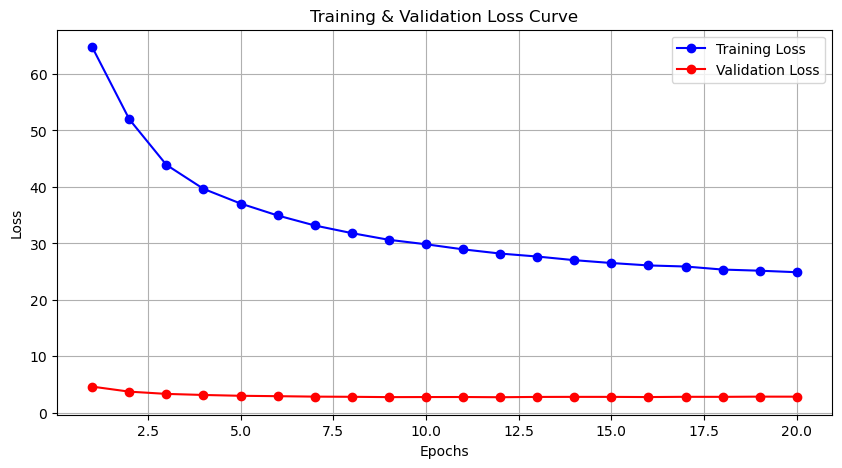

CPU times: total: 9min 51s
Wall time: 12min 5s


In [137]:
%%time
#BERT+LSTM
print('BERT+LSTM type training...')
model_bert_lstm = NER_Model('BERT','LSTM').to(Config.DEVICE)
optimizer = optim.Adam(model_bert_lstm.parameters(), lr=Config.LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
training(model_bert_lstm,'best_bert_LSTM.pth', 'BERT', train_loader_bert, val_loader_bert)

Word2Vec+LSTM type training...


Validating Epoch 1: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.85it/s]


Best model saved!
Epoch 1/20
Train Loss: 1.3855
Val Loss: 1.3624
Val F1: 0.0071



Validating Epoch 2: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.16it/s]


Epoch 2/20
Train Loss: 1.3347
Val Loss: 1.3108
Val F1: 0.0000



Validating Epoch 3: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.75it/s]


Epoch 3/20
Train Loss: 1.2723
Val Loss: 1.2419
Val F1: 0.0000



Validating Epoch 4: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.86it/s]


Epoch 4/20
Train Loss: 1.1840
Val Loss: 1.1401
Val F1: 0.0000



Validating Epoch 5: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.02it/s]


Epoch 5/20
Train Loss: 1.0547
Val Loss: 1.0042
Val F1: 0.0000



Validating Epoch 6: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.61it/s]


Epoch 6/20
Train Loss: 0.9338
Val Loss: 0.9276
Val F1: 0.0000



Validating Epoch 7: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


Epoch 7/20
Train Loss: 0.8960
Val Loss: 0.9135
Val F1: 0.0000



Validating Epoch 8: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.19it/s]


Epoch 8/20
Train Loss: 0.8854
Val Loss: 0.9059
Val F1: 0.0000



Validating Epoch 9: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.47it/s]


Epoch 9/20
Train Loss: 0.8798
Val Loss: 0.9002
Val F1: 0.0000



Validating Epoch 10: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.92it/s]


Epoch 10/20
Train Loss: 0.8754
Val Loss: 0.8950
Val F1: 0.0000



Validating Epoch 11: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.76it/s]


Epoch 11/20
Train Loss: 0.8672
Val Loss: 0.8903
Val F1: 0.0000



Validating Epoch 12: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.23it/s]


Epoch 12/20
Train Loss: 0.8656
Val Loss: 0.8861
Val F1: 0.0000



Validating Epoch 13: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.75it/s]


Epoch 13/20
Train Loss: 0.8579
Val Loss: 0.8815
Val F1: 0.0000



Validating Epoch 14: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.23it/s]


Epoch 14/20
Train Loss: 0.8512
Val Loss: 0.8771
Val F1: 0.0024



Validating Epoch 15: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.60it/s]


Epoch 15/20
Train Loss: 0.8505
Val Loss: 0.8728
Val F1: 0.0048



Validating Epoch 16: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.93it/s]


Epoch 16/20
Train Loss: 0.8432
Val Loss: 0.8677
Val F1: 0.0048



Validating Epoch 17: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.06it/s]


Epoch 17/20
Train Loss: 0.8404
Val Loss: 0.8623
Val F1: 0.0047



Validating Epoch 18: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.67it/s]


Epoch 18/20
Train Loss: 0.8326
Val Loss: 0.8579
Val F1: 0.0023



Validating Epoch 19: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.78it/s]


Best model saved!
Epoch 19/20
Train Loss: 0.8278
Val Loss: 0.8526
Val F1: 0.0092



Validating Epoch 20: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.41it/s]


Epoch 20/20
Train Loss: 0.8232
Val Loss: 0.8480
Val F1: 0.0091



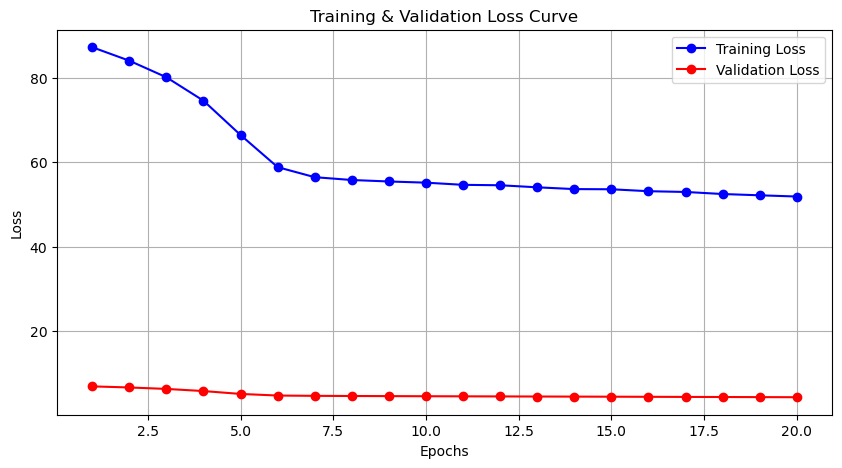

CPU times: total: 2min 4s
Wall time: 2min 11s


In [141]:
%%time
#Word2Vec
print('Word2Vec+LSTM type training...')
model_w2v = NER_Model('Word2Vec').to(Config.DEVICE)
optimizer = optim.Adam(model_w2v.parameters(), lr=Config.LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
training(model_w2v,'best_w2v_LSTM.pth', 'Word2Vec', train_loader, val_loader)

GloVe+LSTM type training...


Validating Epoch 1: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.53it/s]


Best model saved!
Epoch 1/20
Train Loss: 1.3962
Val Loss: 1.3848
Val F1: 0.0921



Validating Epoch 2: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Epoch 2/20
Train Loss: 1.3657
Val Loss: 1.3557
Val F1: 0.0898



Validating Epoch 3: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.32it/s]


Epoch 3/20
Train Loss: 1.3316
Val Loss: 1.3212
Val F1: 0.0417



Validating Epoch 4: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.10it/s]


Epoch 4/20
Train Loss: 1.2886
Val Loss: 1.2758
Val F1: 0.0119



Validating Epoch 5: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.71it/s]


Epoch 5/20
Train Loss: 1.2282
Val Loss: 1.2106
Val F1: 0.0024



Validating Epoch 6: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.22it/s]


Epoch 6/20
Train Loss: 1.1385
Val Loss: 1.1137
Val F1: 0.0000



Validating Epoch 7: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.06it/s]


Epoch 7/20
Train Loss: 1.0264
Val Loss: 1.0111
Val F1: 0.0000



Validating Epoch 8: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.68it/s]


Epoch 8/20
Train Loss: 0.9550
Val Loss: 0.9722
Val F1: 0.0000



Validating Epoch 9: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.81it/s]


Epoch 9/20
Train Loss: 0.9361
Val Loss: 0.9579
Val F1: 0.0000



Validating Epoch 10: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.87it/s]


Epoch 10/20
Train Loss: 0.9244
Val Loss: 0.9476
Val F1: 0.0000



Validating Epoch 11: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.85it/s]


Epoch 11/20
Train Loss: 0.9141
Val Loss: 0.9393
Val F1: 0.0000



Validating Epoch 12: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.03it/s]


Epoch 12/20
Train Loss: 0.9052
Val Loss: 0.9322
Val F1: 0.0000



Validating Epoch 13: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.70it/s]


Epoch 13/20
Train Loss: 0.8984
Val Loss: 0.9259
Val F1: 0.0000



Validating Epoch 14: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.99it/s]


Epoch 14/20
Train Loss: 0.8909
Val Loss: 0.9190
Val F1: 0.0000



Validating Epoch 15: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.94it/s]


Epoch 15/20
Train Loss: 0.8842
Val Loss: 0.9132
Val F1: 0.0000



Validating Epoch 16: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.53it/s]


Epoch 16/20
Train Loss: 0.8810
Val Loss: 0.9079
Val F1: 0.0000



Validating Epoch 17: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.34it/s]


Epoch 17/20
Train Loss: 0.8748
Val Loss: 0.9025
Val F1: 0.0000



Validating Epoch 18: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.51it/s]


Epoch 18/20
Train Loss: 0.8686
Val Loss: 0.8974
Val F1: 0.0000



Validating Epoch 19: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.91it/s]


Epoch 19/20
Train Loss: 0.8639
Val Loss: 0.8933
Val F1: 0.0000



Validating Epoch 20: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.43it/s]


Epoch 20/20
Train Loss: 0.8590
Val Loss: 0.8888
Val F1: 0.0000



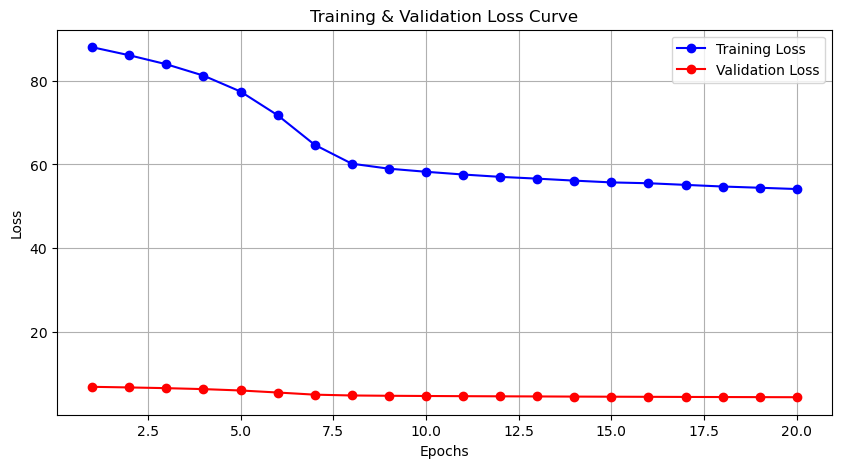

CPU times: total: 2min 1s
Wall time: 2min 13s


In [143]:
%%time
#GloVe
print('GloVe+LSTM type training...')
model_glove = NER_Model('GloVe').to(Config.DEVICE)
optimizer = optim.Adam(model_glove.parameters(), lr=Config.LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
training(model_glove, 'best_glove_LSTM.pth', 'GloVe', train_loader, val_loader)

## 2.2 vary the neural layer  
a. Data pre-processing technique: no preprocessing  
b. Text encoding/transformation into embeddings: pre-trained language model(BERT)  
c. (varied) Modelling Technique: RNN with FC layer, LSTM with FC layer (from 2.1), Transformers(including in 2.3)

BERT+RNN type training...


Validating Epoch 1: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.45it/s]


Best model saved!
Epoch 1/20
Train Loss: 0.8649
Val Loss: 0.6198
Val F1: 0.6177



Validating Epoch 2: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


Best model saved!
Epoch 2/20
Train Loss: 0.5529
Val Loss: 0.5399
Val F1: 0.7745



Validating Epoch 3: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


Best model saved!
Epoch 3/20
Train Loss: 0.5023
Val Loss: 0.5316
Val F1: 0.7960



Validating Epoch 4: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


Best model saved!
Epoch 4/20
Train Loss: 0.4791
Val Loss: 0.5383
Val F1: 0.7972



Validating Epoch 5: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


Best model saved!
Epoch 5/20
Train Loss: 0.4648
Val Loss: 0.5403
Val F1: 0.8051



Validating Epoch 6: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.07it/s]


Epoch 6/20
Train Loss: 0.4552
Val Loss: 0.5280
Val F1: 0.8005



Validating Epoch 7: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 7/20
Train Loss: 0.4456
Val Loss: 0.5315
Val F1: 0.8005



Validating Epoch 8: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.76it/s]


Epoch 8/20
Train Loss: 0.4344
Val Loss: 0.5492
Val F1: 0.8016



Validating Epoch 9: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 9/20
Train Loss: 0.4245
Val Loss: 0.5409
Val F1: 0.8050



Validating Epoch 10: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


Epoch 10/20
Train Loss: 0.4170
Val Loss: 0.5656
Val F1: 0.8036



Validating Epoch 11: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


Best model saved!
Epoch 11/20
Train Loss: 0.4100
Val Loss: 0.5693
Val F1: 0.8068



Validating Epoch 12: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


Epoch 12/20
Train Loss: 0.4040
Val Loss: 0.5913
Val F1: 0.8023



Validating Epoch 13: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


Epoch 13/20
Train Loss: 0.3980
Val Loss: 0.5840
Val F1: 0.8033



Validating Epoch 14: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


Best model saved!
Epoch 14/20
Train Loss: 0.3902
Val Loss: 0.5898
Val F1: 0.8173



Validating Epoch 15: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


Epoch 15/20
Train Loss: 0.3865
Val Loss: 0.5809
Val F1: 0.8125



Validating Epoch 16: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


Epoch 16/20
Train Loss: 0.3820
Val Loss: 0.5929
Val F1: 0.8069



Validating Epoch 17: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]


Epoch 17/20
Train Loss: 0.3782
Val Loss: 0.5949
Val F1: 0.8113



Validating Epoch 18: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]


Epoch 18/20
Train Loss: 0.3770
Val Loss: 0.5902
Val F1: 0.8098



Validating Epoch 19: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


Epoch 19/20
Train Loss: 0.3739
Val Loss: 0.5991
Val F1: 0.8010



Validating Epoch 20: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


Epoch 20/20
Train Loss: 0.3712
Val Loss: 0.6037
Val F1: 0.8084



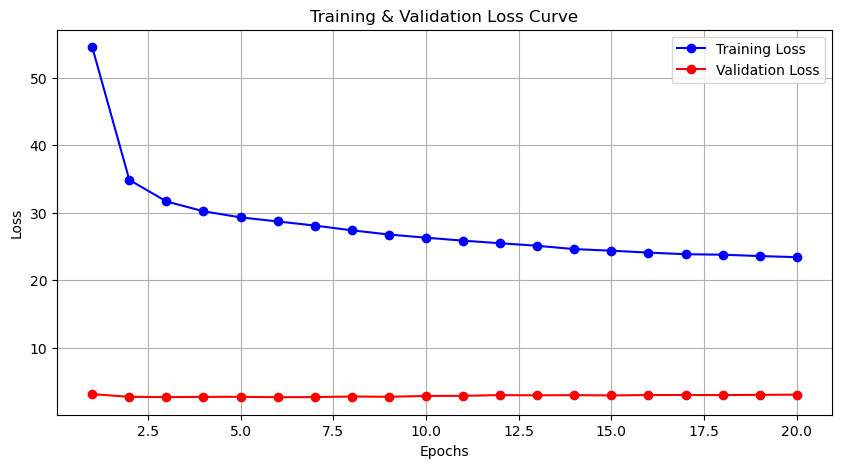

CPU times: total: 10min 3s
Wall time: 11min 18s


In [139]:
%%time
#BERT+RNN
print('BERT+RNN type training...')
model_bert_rnn = NER_Model('BERT','RNN').to(Config.DEVICE)
optimizer = optim.Adam(model_bert_rnn.parameters(), lr=Config.LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
training(model_bert_rnn,'best_bert_RNN.pth', 'BERT', train_loader_bert, val_loader_bert)

## 2.3 adding additional data to the training set  
a. Training: 2000 (from 2.2), 4000, 8000  
Running the notebook individually is recommended

In [ ]:
%run ./bert.ipynb

# 3. Analyse testing for each of the three experiment setup variations

In [220]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def flatten_sequences(tags):
    return [label for seq in tags for label in seq]

def testing(model, model_name, embedding_type, test_loader):
    model.load_state_dict(torch.load(model_name))
    model.eval()
    
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            if embedding_type == 'BERT':#BERT
                logits = model(None, None, batch['input_ids'], batch['attention_mask'])
                preds = torch.argmax(logits, dim=-1).cpu().numpy()
                labels = batch['labels'].cpu().numpy()

                for i in range(preds.shape[0]):
                    valid_labels = []
                    valid_preds = []
                    for j in range(preds.shape[1]):
                        if labels[i][j] != -100:
                            valid_labels.append(id2ner[labels[i][j]])
                            valid_preds.append(id2ner[preds[i][j]])
                    all_labels.append(valid_labels)
                    all_preds.append(valid_preds)
            else:
                logits = model(batch['token_ids'], batch['lengths'], None, None)
                preds = torch.argmax(logits, dim=-1).cpu().numpy()
                labels = batch['ner_ids'].cpu().numpy()

                for i in range(len(batch['lengths'])):
                    valid_preds = []
                    valid_labels = []
                    length = batch['lengths'][i]
                    result_preds = preds[i, :length]
                    result_labels = labels[i, :length]
                    mask = result_labels != -100
                    for i in result_preds[mask].tolist():
                        valid_preds.append(id2ner[i])
                    for i in result_labels[mask].tolist():
                        valid_labels.append(id2ner[i])
                    all_preds.append(valid_preds)
                    all_labels.append(valid_labels)

    precision, recall, f1, report = eval_ner(all_labels, all_preds)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    labels = [v for k,v in enumerate(ner_tag2id)]
    flat_true = flatten_sequences(all_labels)
    flat_pred = flatten_sequences(all_preds)
    cm = confusion_matrix(flat_true, flat_pred, labels=labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d',xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Token-level Confusion Matrix')
    plt.show()

## 3.1

Word2Vec type testing...


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 16.12it/s]
C:\Users\darkn\anaconda3\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0602
Recall: 0.0039
F1: 0.0073


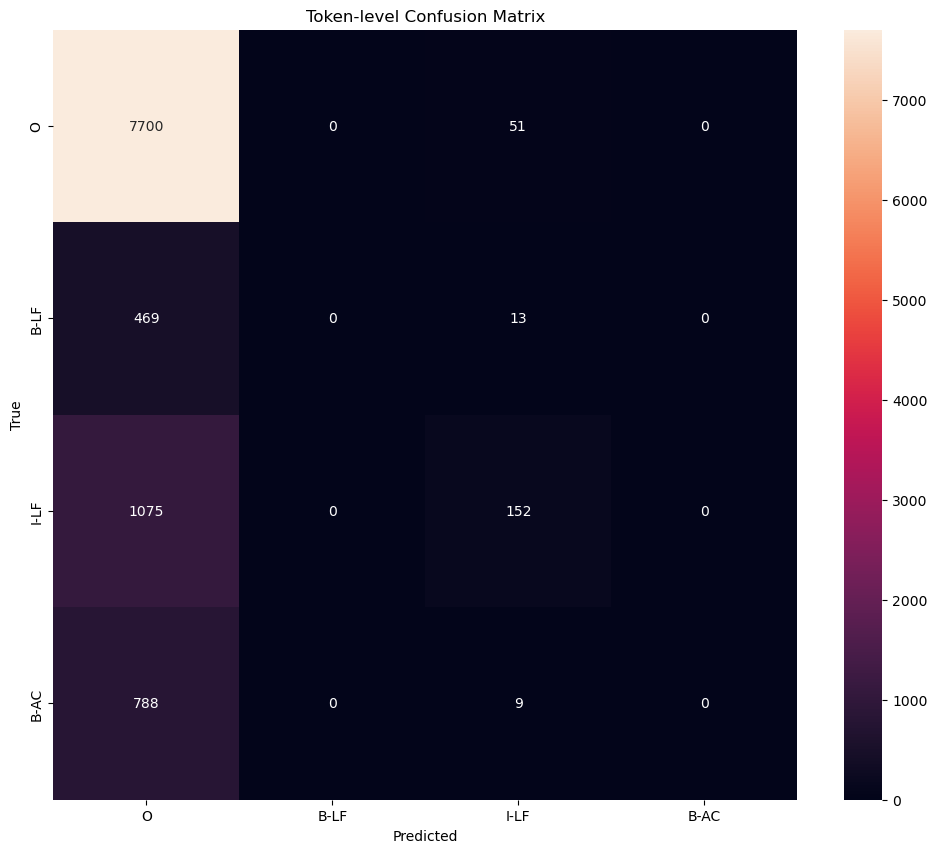

GloVe type testing...


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.88it/s]


Precision: 0.0490
Recall: 0.3135
F1: 0.0847


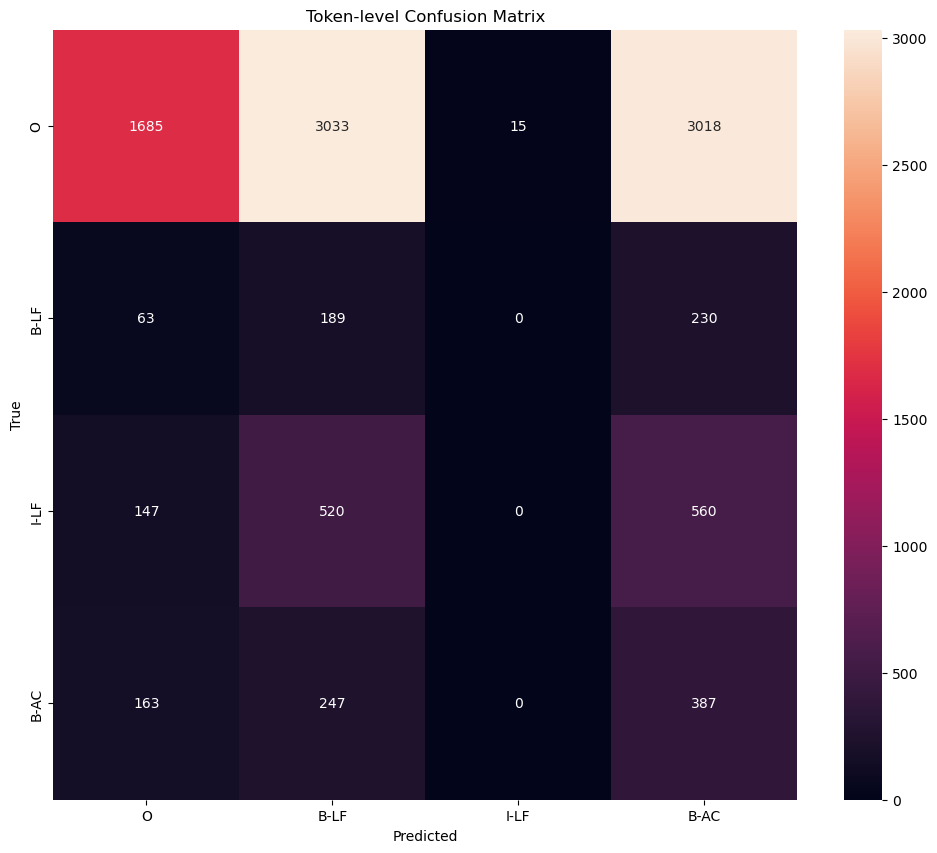

BERT+LSTM type testing...


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 11.97it/s]


Precision: 0.7894
Recall: 0.9103
F1: 0.8456


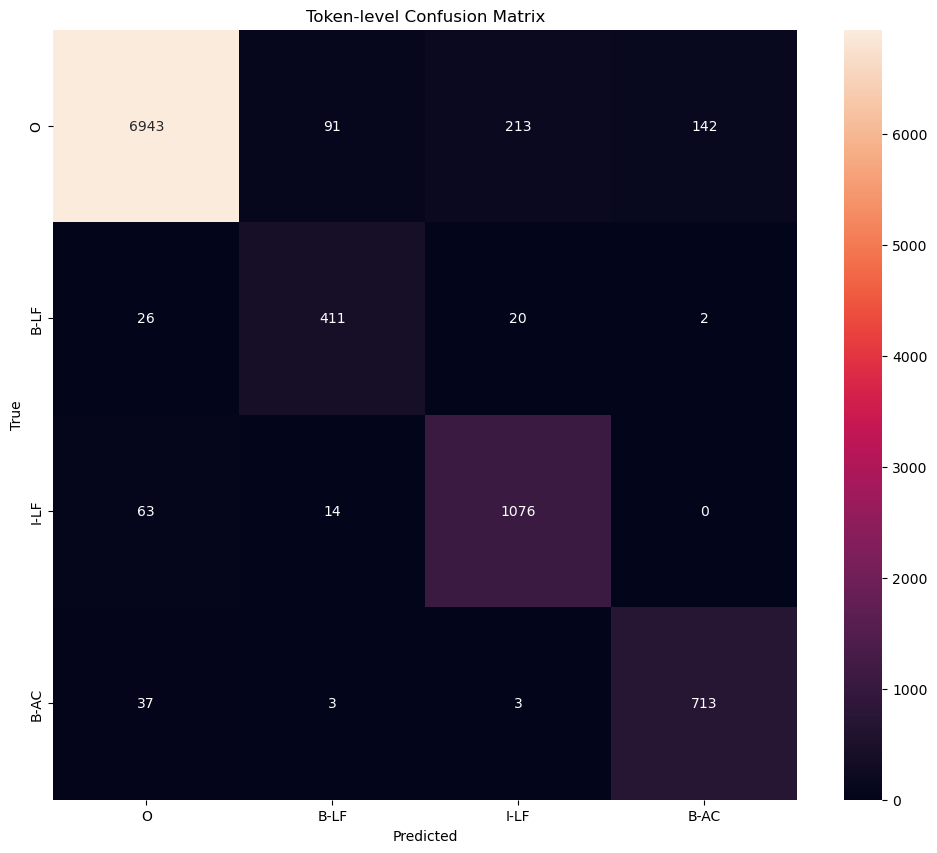

In [222]:
print('Word2Vec type testing...')
testing(model_w2v,'best_w2v_LSTM.pth', 'Word2Vec', test_loader)
print('GloVe type testing...')
testing(model_glove,'best_glove_LSTM.pth', 'GloVe', test_loader)
print('BERT+LSTM type testing...')
testing(model_bert_lstm,'best_bert_LSTM.pth', 'BERT', test_loader_bert)

## 3.2

BERT+LSTM type testing...


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 11.18it/s]


Precision: 0.7894
Recall: 0.9103
F1: 0.8456


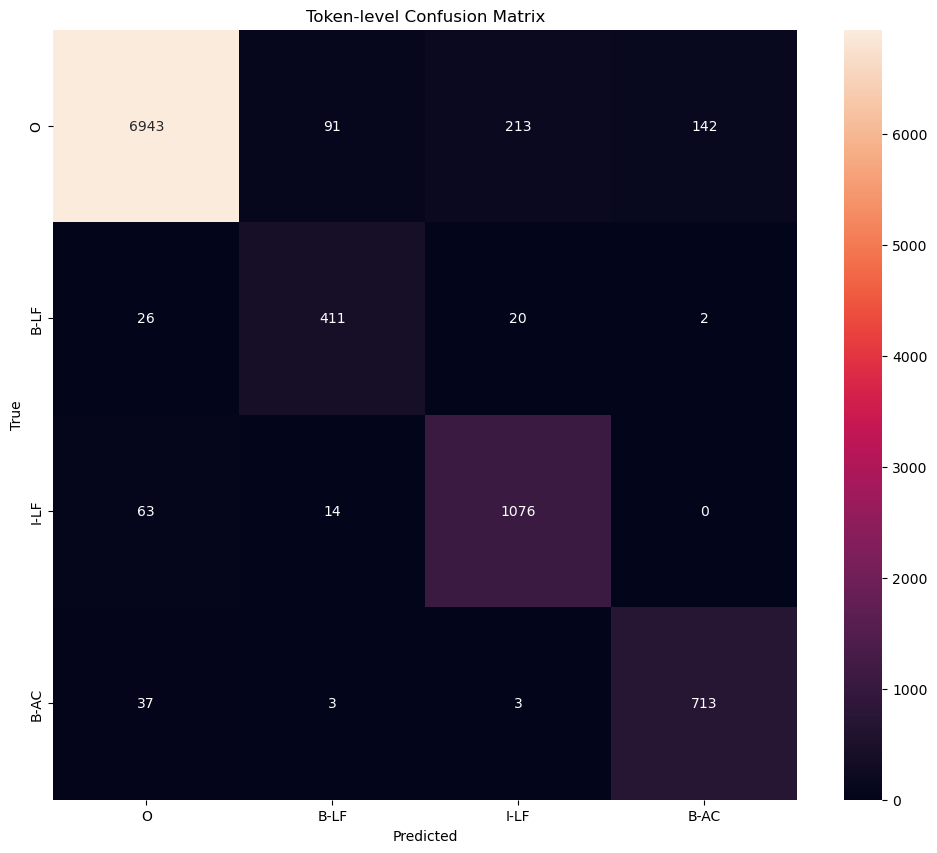

BERT+RNN type testing...


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.35it/s]


Precision: 0.7908
Recall: 0.9210
F1: 0.8510


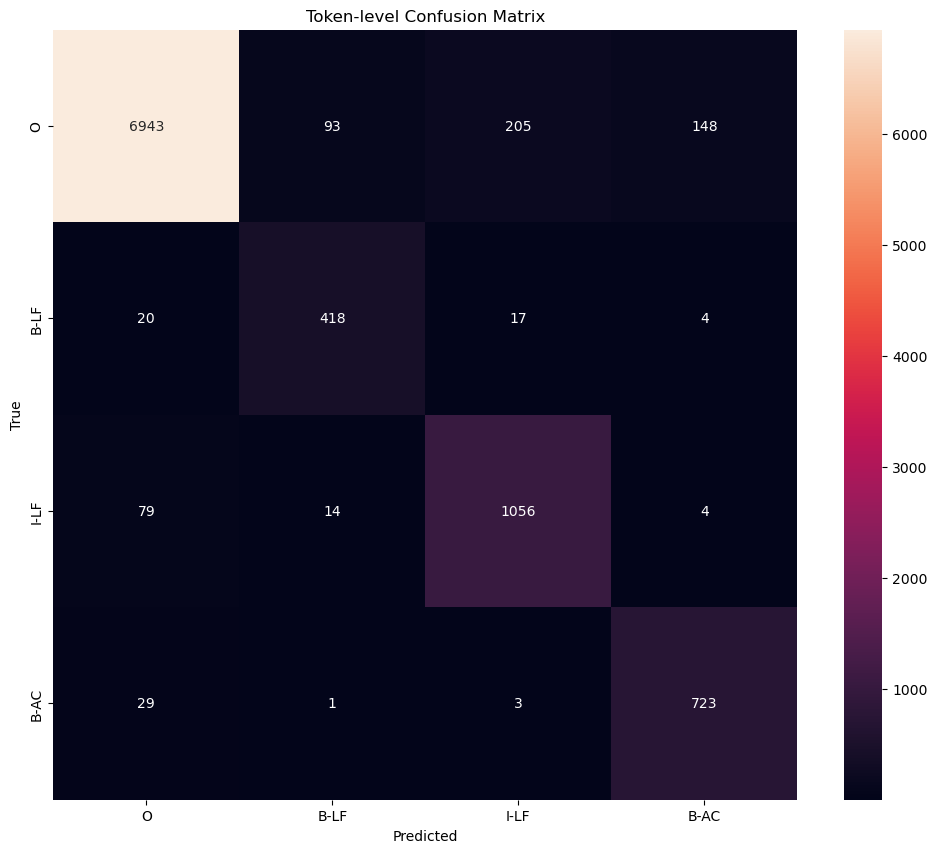

In [225]:
print('BERT+LSTM type testing...')
testing(model_bert_lstm,'best_bert_LSTM.pth', 'BERT', test_loader_bert)
print('BERT+RNN type testing...')
testing(model_bert_rnn,'best_bert_RNN.pth', 'BERT', test_loader_bert)

## 3.3

Please see bert.ipynb

# 4. Perform an error analysis on the predictions obtained

Please see bert.ipynb

# Hosting The Model
Running the python code directly is recommended since there may be command line input to select local model

In [ ]:
!python token_classification.py